### Notebook to analyze the data from the real scMS samples
Figure 4  
Each method was processed with an extra jupyter notebook before.

In [15]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import sceptre as spt
from sklearn import metrics
from matplotlib_venn import venn3_unweighted

In [16]:
# create result folder
res_dir = '../results/comparison/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [17]:
random_state = 1

In [18]:
# set figsize for scanpys scatterplot panels
plt.rcParams['figure.figsize'] = (2, 2)
cellsize= 30 # size to plot cells

In [19]:
# import adatas

methods = ['MS2_500', 'MS2_750', 'MS3_500', 'MS3_750', 'RETICLE_500', 'RETICLE_750']
method_dict = {'MS2_500': 'MS2 500ms', 'MS2_750': 'MS2 750ms', 'MS3_500': 'RTS-MS3 500ms', 'MS3_750': 'RTS-MS3 750ms', 'RETICLE_500': 'RETICLE 500ms', 'RETICLE_750': 'RETICLE 750ms'}
adatas = {}
for m in methods:
    adatas[m] = sc.read(f'../results/scMS/{m}/{m}.h5ad')

/home/bfurtwa/miniconda3/envs/sceptre/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'File ID' as categorical
/home/bfurtwa/miniconda3/envs/sceptre/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'File Name' as categorical
/home/bfurtwa/miniconda3/envs/sceptre/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be

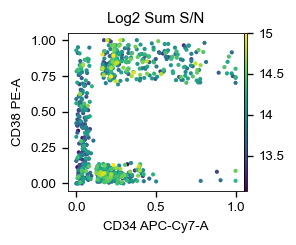

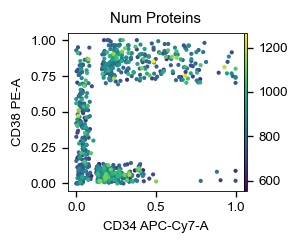

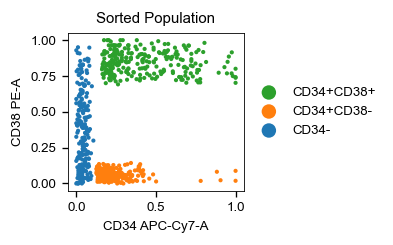

In [20]:
# plot facs data

ad = sc.AnnData.concatenate(*adatas.values(), join='outer', batch_key='method', batch_categories=adatas.keys(), fill_value=0)
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
ad.uns['Sorted Population_colors'] = [cols[2], cols[1], cols[0]]

figs = spt.plot_facs_qc(ad, 'CD34 APC-Cy7-A', 'CD38 PE-A', labels=['Log2 Sum S/N', 'Num Proteins', 'Sorted Population'], figsize=(2.8, 1.8))
figs[-1].savefig(res_dir + 'facs.pdf', bbox_inches='tight', transparent=True)

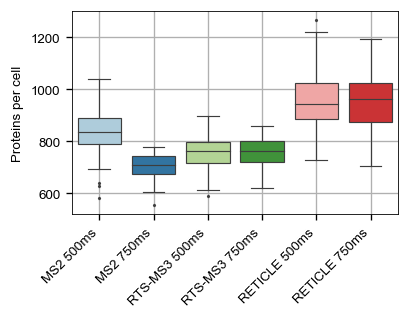

In [21]:
# proteins per cell

prot_per_cell = {}
for m in methods:
    prot_per_cell[m] = (~pd.DataFrame(adatas[m].raw.X.T).replace(0, pd.NA).isna()).sum().tolist()
prot_per_cell = pd.DataFrame.from_dict(prot_per_cell, orient='index').T.melt().dropna()
prot_per_cell = prot_per_cell.rename(columns={'variable': 'Method', 'value': 'Proteins per cell'})
prot_per_cell['Method'] = prot_per_cell['Method'].replace(method_dict)

fig, ax = plt.subplots(figsize=(3.5, 2.2))
sns.boxplot(data=prot_per_cell, x='Method', y='Proteins per cell', ax=ax, palette='Paired', fliersize=1)
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axes.get_xaxis().get_label().set_visible(False)
plt.savefig(res_dir + 'prot_per_cell.pdf', transparent=True, bbox_inches='tight')

In [22]:
# median proteins per cell

prot_per_cell.groupby('Method').median()

,Proteins per cell
Method,
MS2 500ms,836.5
MS2 750ms,710.5
RETICLE 500ms,943.0
RETICLE 750ms,961.5
RTS-MS3 500ms,761.5
RTS-MS3 750ms,765.0


In [23]:
# proteins with at least 70% coverage

for m in methods:
    print(m)
    ad = adatas[m].raw.to_adata()
    # calculate fraction of missing values for each protein
    frac_missing = ((ad.X.shape[0] - np.count_nonzero(ad.X, axis=0)) / ad.X.shape[0] * 100)
    print((frac_missing <= 30).sum())

MS2_500
649
MS2_750
557
MS3_500
558
MS3_750
560
RETICLE_500
668
RETICLE_750
688


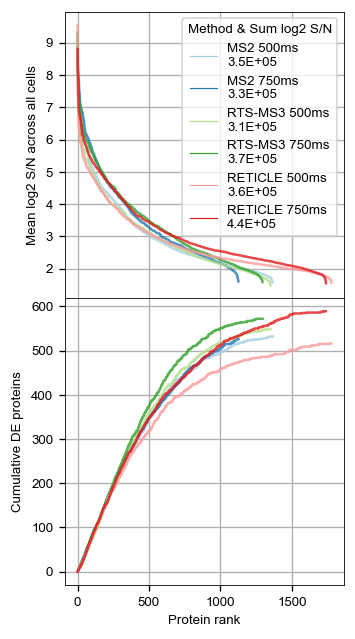

In [24]:
# distribution of sn across proteins

mean_sn = {}
sum_sn = {}
for m in methods:
    ad = adatas[m].raw.to_adata()
    mean_sn[m] = pd.DataFrame({'mean_sn': pd.DataFrame(ad.X.T).replace(0, pd.NA).mean(axis=1)})
    mean_sn[m] = mean_sn[m].set_index(ad.var_names)
    mean_sn[m]['rank'] = mean_sn[m]['mean_sn'].rank(method='first', ascending=False).astype(int)
    sum_sn[m] = ad.X.sum()
all_prots = pd.DataFrame({'rank':[i for i in range(1, max([x['rank'].max() for x in mean_sn.values()])-1)]})
for m in methods:
    all_prots = all_prots.merge(mean_sn[m], on='rank', how='left')
    all_prots.columns = list(all_prots.columns[:-1]) + [m]
all_prots = all_prots.melt(id_vars=['rank'])
all_prots.columns = ['rank', 'Method & Sum log2 S/N', 'value']
all_prots['Method & Sum log2 S/N'] = all_prots['Method & Sum log2 S/N'].apply(lambda x: f'{method_dict[x]}\n{int(round(sum_sn[x],0)):.1E}')

fig, axs = plt.subplots(2, 1, figsize=(3, 6.2), sharex=True, gridspec_kw={'hspace':0.0})
ax = axs[0]
sns.lineplot(data=all_prots, x='rank', y='value', hue='Method & Sum log2 S/N', palette='Paired', ax=ax, linewidth=1.5, alpha=0.8)
ax.set_ylabel('Mean log2 S/N across all cells')
ax.set_xlabel('Protein rank')
ax.grid()

# distribution of DE prots
fc = 0.0
group = 'CD34+CD38+'
all_de_prots = pd.DataFrame({'rank':[i for i in range(1, max([x['rank'].max() for x in mean_sn.values()])-1)]})
for m in methods:
    spt.de_test(adatas[m], by='Sorted Population', group1=group, key=group)
    de_g = adatas[m].uns[group]['results']
    de_g = de_g[((de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] >= fc)) | ((de_g['pval_adj'] <= 0.05) & (de_g['log2foldchange'] <= -fc))]['gene'].values
    df = mean_sn[m].sort_values('rank')
    df['de_g'] = df.index.isin(de_g)
    df['de_cumsum'] = np.cumsum(df['de_g'])
    all_de_prots = all_de_prots.merge(df[['rank', 'de_cumsum']], on='rank', how='left')
    all_de_prots.columns = list(all_de_prots.columns[:-1]) + [m]
all_de_prots = all_de_prots.melt(id_vars=['rank'])
all_de_prots.columns = ['rank', 'Method', 'value']

ax = axs[1]
sns.lineplot(data=all_de_prots, x='rank', y='value', hue='Method', palette='Paired', ax=ax, linewidth=1.5, alpha=0.8)
ax.set_ylabel('Cumulative DE proteins')
ax.set_xlabel('Protein rank')
ax.get_legend().remove()
ax.grid()

plt.savefig(res_dir + 'sn_distribution.pdf', transparent=True, bbox_inches='tight')

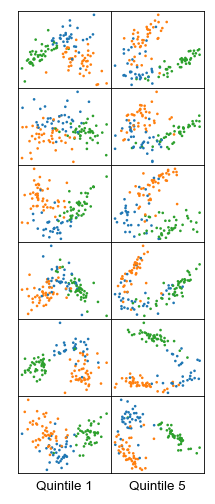

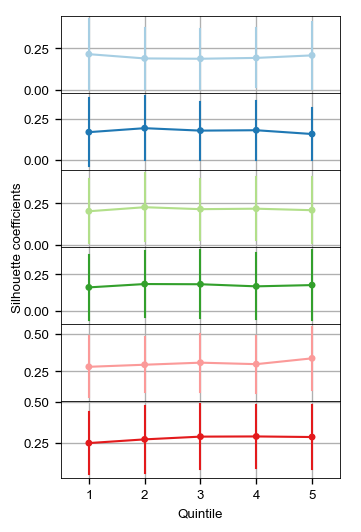

In [25]:
# population separation in PCA

verb = sc.settings.verbosity
sc.settings.verbosity = 0

sils = []

fig = plt.figure(figsize=(2, 5))
plot_count = 0

for m in methods:
    df = mean_sn[m][mean_sn[m].index.isin(adatas[m].var_names)].copy()
    df['bin'] = pd.cut(df['rank'], 5)
    for j in range(5):
        b = df['bin'].cat.categories[j]
        genes = df[df['bin']==b].index
        ad = adatas[m][:, genes].copy()
        sc.pp.pca(ad)
        sil = pd.Series(metrics.silhouette_samples(ad.obsm['X_pca'][:, :10], ad.obs['Sorted Population']), name=m)
        [sils.append({'Method': m, 'Loc': j+1, 'Silhuettes': x}) for x in sil.values]
        
        if j==0 or j==4:
            ax = fig.add_subplot(6, 2, plot_count+1)
            plot_count += 1
            sc.pl.pca(ad, color='Sorted Population', size=10, show=False, ax=ax, annotate_var_explained=True, title='', legend_loc=None)
            ax.set_xlabel('')
            ax.set_ylabel('')
            if m=='RETICLE_750':
                if j==0:
                    ax.set_xlabel('Quintile 1')
                if j==4:
                    ax.set_xlabel('Quintile 5')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(res_dir + 'pcas.pdf', transparent=True, bbox_inches='tight')

sils = pd.DataFrame(sils)
sc.settings.verbosity = verb

fig, axs = plt.subplots(6, 1, figsize=(3, 5), sharex=True, gridspec_kw={'hspace': 0.0})
cmap = plt.get_cmap("Paired")
for i, m in enumerate(methods):
    sns.pointplot(data=sils[sils['Method']==m], x='Loc', y='Silhuettes', ax=axs[i], color=cmap(i), ci='sd')
    axs[i].grid()
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Quintile')
plt.ylabel('Silhouette coefficients')
plt.savefig(res_dir + 'silhuettes.pdf', transparent=True, bbox_inches='tight')

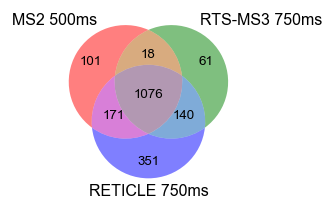

In [26]:
# compare numbers in MS2 500ms, RTS-MS3 750ms & RETICLE 750ms

# common proteins
common_prots = adatas['MS2_500'].var_names[adatas['MS2_500'].var_names.isin(adatas['MS3_750'].var_names)]
common_prots = adatas['RETICLE_750'].var_names[adatas['RETICLE_750'].var_names.isin(common_prots)]
# unique proteins
uMS2_500 = adatas['MS2_500'].var_names[~((adatas['MS2_500'].var_names.isin(adatas['MS3_750'].var_names)) | (adatas['MS2_500'].var_names.isin(adatas['RETICLE_750'].var_names)))]
uMS3_750 = adatas['MS3_750'].var_names[~((adatas['MS3_750'].var_names.isin(adatas['MS2_500'].var_names)) | (adatas['MS3_750'].var_names.isin(adatas['RETICLE_750'].var_names)))]
uRETICLE_750 = adatas['RETICLE_750'].var_names[~((adatas['RETICLE_750'].var_names.isin(adatas['MS2_500'].var_names)) | (adatas['RETICLE_750'].var_names.isin(adatas['MS3_750'].var_names)))]
# pairwise overlaps
MS2_500_MS3_750 = adatas['MS2_500'].var_names[(adatas['MS2_500'].var_names.isin(adatas['MS3_750'].var_names)) & ((~adatas['MS2_500'].var_names.isin(common_prots)))]
MS2_500_RETICLE_750 = adatas['MS2_500'].var_names[(adatas['MS2_500'].var_names.isin(adatas['RETICLE_750'].var_names)) & (~adatas['MS2_500'].var_names.isin(common_prots))]
MS3_750_RETICLE_750 = adatas['MS3_750'].var_names[(adatas['MS3_750'].var_names.isin(adatas['RETICLE_750'].var_names)) & (~adatas['MS3_750'].var_names.isin(common_prots))]

fig, ax = plt.subplots(figsize=(2, 2))
f = venn3_unweighted(subsets=(len(uMS2_500), len(uMS3_750), len(MS2_500_MS3_750), len(uRETICLE_750), len(MS2_500_RETICLE_750), len(MS3_750_RETICLE_750), len(common_prots)),
      set_labels=('MS2 500ms', 'RTS-MS3 750ms', 'RETICLE 750ms'), alpha=0.5, ax=ax)
plt.savefig(res_dir + 'venn.pdf', transparent=True, bbox_inches='tight')

Method
MS2 500ms        2485
RETICLE 750ms    2485
RTS-MS3 750ms    2485
dtype: int64
Method
RETICLE 750ms    290
dtype: int64


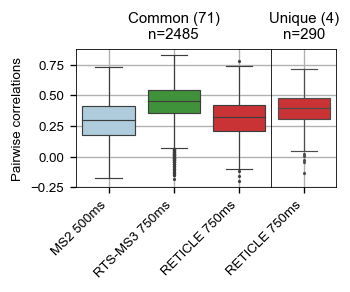

In [27]:
# compare quantification of ribosomes
common_ribo = adatas['RETICLE_750'].var_names[((adatas['RETICLE_750'].var['Description'].str.contains('40S')) | (adatas['RETICLE_750'].var['Description'].str.contains('60S'))) & (adatas['RETICLE_750'].var_names.isin(common_prots))]
reticle_ribo = adatas['RETICLE_750'].var_names[((adatas['RETICLE_750'].var['Description'].str.contains('40S')) | (adatas['RETICLE_750'].var['Description'].str.contains('60S'))) & (adatas['RETICLE_750'].var_names.isin(uRETICLE_750))]

pairwise_corrs = []
# pairwise correlations
for m in ['MS2_500', 'MS3_750', 'RETICLE_750']:
    df = adatas[m][:, common_ribo].X
    df = pd.DataFrame(np.triu(pd.DataFrame(df).corr(method='pearson'), 1)).replace(0, np.nan).values
    corrs = [l for subl in df for l in subl]
    corrs = [x for x in corrs if not np.isnan(x)]
    for c in corrs:
        pairwise_corrs.append({'Method': m, 'corr': c})

# extra reticle pairwise with all other
pairwise_corrs_extra_ret = []
df = adatas[m][:, list(common_ribo) + list(reticle_ribo)].X
df = pd.DataFrame(np.triu(pd.DataFrame(df).corr(method='pearson'), 1)).replace(0, np.nan).iloc[:, -4:].values
corrs = [l for subl in df for l in subl]
corrs = [x for x in corrs if not np.isnan(x)]
for c in corrs:
    pairwise_corrs_extra_ret.append({'Method': 'RETICLE 750ms', 'corr': c})

pairwise_corrs = pd.DataFrame(pairwise_corrs)
pairwise_corrs_extra_ret = pd.DataFrame(pairwise_corrs_extra_ret)
pairwise_corrs['Method'] = pairwise_corrs['Method'].replace(method_dict)

cmap = plt.get_cmap("Paired")

fig, axs = plt.subplots(1, 2, figsize=(2.8, 1.5), sharey=True, gridspec_kw={'wspace':0,'width_ratios': [3, 1]})
ax = axs[0]
sns.boxplot(data=pairwise_corrs, y='corr', x='Method', fliersize=1, ax=ax, palette={'MS2 500ms': cmap(0), 'RTS-MS3 750ms': cmap(3), 'RETICLE 750ms': cmap(5)})
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axes.get_xaxis().get_label().set_visible(False)
ax.set_ylabel('Pairwise correlations')
ax.set_title(f'Common ({len(common_ribo)})\nn={pairwise_corrs.groupby("Method").size()[0]}')

ax = axs[1]
sns.boxplot(data=pairwise_corrs_extra_ret, y='corr', x='Method', fliersize=1, ax=ax, palette={'RETICLE 750ms': cmap(5)})
ax.axes.get_yaxis().get_label().set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid()
ax.yaxis.set_ticks_position('none')
ax.axes.get_xaxis().get_label().set_visible(False)
ax.set_title(f'Unique ({len(reticle_ribo)})\nn={pairwise_corrs_extra_ret.groupby("Method").size()[0]}')

plt.savefig(res_dir + 'ribosome_correlations.pdf', transparent=True, bbox_inches='tight')
print(pairwise_corrs.groupby('Method').size())
print(pairwise_corrs_extra_ret.groupby('Method').size())

In [28]:
os.system('jupyter nbconvert --to html comparison.ipynb --output-dir={}'.format(res_dir))

[NbConvertApp] Converting notebook comparison.ipynb to html
[NbConvertApp] Writing 1073494 bytes to ../results/comparison/comparison.html


0